<center style="font-size: 16px; font-weight: normal">
  `21 Microservices Architecture Patterns Study</center>

<center><h1>Chapter 7. Aggregates and Consistency Boundaries</h1></center>

<center>
  Joseph Kim &lt;cloudeyes@gmail.com&gt;<br/>
  Jan 28. 2021<br/>
</center>

<center>
  <img src="https://images-na.ssl-images-amazon.com/images/I/51-q9CWNBHL._SX379_BO1,204,203,200_.jpg" style="width: 200px">
</center>

<center>
  <a href="https://github.com/cloudeyes/2021-msa-study/blob/main/07-aggregates-boundaries/07-aggregates-boundaries.ipynb">Download Jupyter Notebook</a>
</center>

# 07. Aggregates and Consistency Boundaries

## Introduction

### Sanity Checks for the project

#### Project structure

In [1]:
!tree app -I '__pycache__' --sort=version

app
├── __init__.py
├── __main__.py
├── adapters
│   ├── __init__.py
│   ├── orm.py
│   └── repository.py
├── apps
│   ├── __init__.py
│   ├── fastapi.py
│   └── flask.py
├── config.py
├── domain
│   ├── __init__.py
│   └── models.py
├── requirements.txt
├── routes
│   ├── __init__.py
│   └── flask.py
└── services
    ├── __init__.py
    ├── batch.py
    └── uow.py

5 directories, 17 files


In [2]:
!mypy -p app --strict

Success: no issues found in 16 source files


In [3]:
!pylint app


--------------------------------------------------------------------
Your code has been rated at 10.00/10 (previous run: 10.00/10, +0.00)



In [4]:
!pytest

============================= test session starts ==============================
platform linux -- Python 3.9.1, pytest-6.1.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/ykkim/notebooks/2021-msa-study/07-aggregates-boundaries
plugins: flask-1.1.0, anyio-2.0.2
collected 32 items                                                             

tests/e2e/test_api.py .                                                  [  3%]
tests/integration/test_orm.py ......                                     [ 21%]
tests/integration/test_repository.py ..                                  [ 28%]
tests/integration/test_uow.py ....                                       [ 40%]
tests/unit/test_allocate.py ....                                         [ 53%]
tests/unit/test_batch.py .........                                       [ 81%]
tests/unit/test_services.py ......                                       [100%]

============================== 32 passed in 1.06s ==============================


### 테스트 피라미드는?

In [5]:
from tests.utils import get_test_counts, show_test_pyramid
test_counts = get_test_counts(); test_counts

{'unit': 20, 'integration': 12, 'e2e': 1}

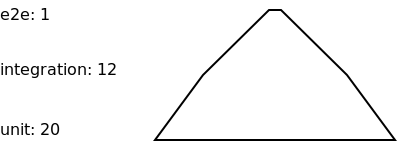

In [6]:
show_test_pyramid(test_counts)

## Why Not Just Run Everything in a Spreadsheet?

이메일로 스프레드시트 파일을 교환하며 일하는 것은 흔한 방법입니다. 하지만 이 방법으로는 대규모 변경이나 제약조건을 케어하기 어렵습니다.
특히 이메일 수신자가 여러명이고 이 사용자들이 동시에 셀을 수정하거나 변경했다고 하면 변경 충돌을 제대로 병합할 수가 없습니다.

시스템의 제약 조건, 즉, 불변성(invariants)을 만족시킬 수 있는 작업이 필요합니다. 

**[개인적인 생각]**

- 스프레드시트에도 셀에 제약조건을 걸 수 있긴 합니다.
- 스프레드시트를 공유할 경우 셀에 동시에 여러 사용자가 수정하는 것을 방지할 수 있는 것으로 알고 있습니다.
- 하지만 이게 스프레드시트를 이메일로 공유하는 방식은 아니니까 넘어갑시다.

## Invariants, Constraints, and Consistency

이 책에서 계속 만들고 있는 MADE.COM(가구 리테일 시스템)의 비즈니스 규칙으로부터 불변 조건을 생각해봅시다.

> An order line can be allocated to only one batch at a time.

한 주문선은 오직 한 배치에만 할당될 수 있다는 조건입니다. 즉 다음과 같은 관계를 암시합니다.

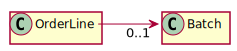

In [7]:
%%plantuml
@startuml ../images/orderline-relation
hide members
left to right direction

class OrderLine
class Batch

OrderLine --> "0..1" Batch

@enduml

![](images/orderline-relation.svg)

하지만 현재 `allocate` 서비스 함수에는 이런 제약조건의 유효성 검사 규칙이 없습니다. `can_allocate`를 만족하는 한, 동일한 `OrderLine`에 같은 배치를 여러번 할당 할 수 있습니다.

```python

def allocate(line: OrderLine, batches: list[Batch]) -> str:
    """주어진 배치들 중 할당 가능하고  가장 ETA가 빠른 배치를 주문선 `line`에 할당합니다.

    Raises:
        :class:`OutOfStock` 할당 가능한 배치가 없을 때 발생하는 예외.
    """
    try:
        batch = next(b for b in sorted(batches) if b.can_allocate(line))
        batch.allocate(line)
        return batch.reference
    except StopIteration as ex:
        raise OutOfStock(f'Out of stock for sku {line.sku}') from ex
```

**[의문점]**

- 이럴거면 왜 `Batch` 와 `OrderLine` 관계를 N:M 구조로 모델링 했는지 이해할 수 없네요. 계속 살펴봅시다.

### Invariants, Concurrency, and Locks

동시성 문제가 더해지면 불변성 제약을 만족시키란 더 어려워집니다. 다음 비즈니스 규칙을 생각해봅시다.

> We can’t allocate to a batch if the available quantity is less than the quantity of the order line.

위의 `allocate` 서비스 함수 구현을 보면 `can_allocate` 함수를 통해 이 조건에 대한 유효성 검사가 이뤄지고 있다는 것을 알 수 있습니다. 하지만 동시에 여러 작업이 처리되는 경우 할당 후 커밋 전에 다른 스레드/프로세스에서 재고가 있는 것으로 간주되어 중복으로 할당할 수 있습니다.

물론 DB 행이나 테이블에 락을 걸면 간단히 해결되는 경우도 있지만, 이 경우 락으로 인한 성능 저하가 발생합니다. 더 큰 문제점은 불변성 검사를 해야 하는 객체들이 늘어나면서 관리 복잡성이 증가하고 잘못된 락에 의한 데드락의 위험이 커지게 된다는 점입니다.

불변성을 만족해야 하는 객체들을 보다 효과적으로 관리할 방법이 있을까요?

## What Is an Aggregate?

이런 문제를 해결하는 방법으로 DDD 커뮤니티에서는 **Aggregate 패턴** 을 제시합니다.

전체 데이터베이스에 락을 거는 대신, 불변성을 만족하는 논리적인 "덩어리"를 만드는 것입니다.

예를 들어 동일한 품목(SKU)을 여러 사용자가 동시에 할당하려 할경우 과할당 되는 동시성 문제가 발생 가능하지만
서로 다른 품목들을 동시에 할당하는 것은 문제가 발생하지 않습니다.

이런 동일 품목 단위의 객체들을 "덩어리(Aggregate)"로 뭉쳐서 별도의 모델로 정의하고 이 덩어리 모델에 대한 메소드를 호출하여 동시성 문제를 해결하고, 여러 객체간의 복잡한 상화작용을 단순화하며, 처리 성능을 최적화하는 것이 Aggregate 패턴의 핵심 아이디어 입니다.

유식한 말로 "불변성 지키는 책임을 가진 객체들이 모인 단일 일관성의 경계(a single consistency boundary)"를 찾는 것입니다. 쇼핑몰의 장바구니가 대표적인 예라고 할 수 있습니다.

에릭 에반스는 그의 저서인 DDD에서 다음과 같이 Aggregate를 정의합니다. 

> An AGGREGATE is a cluster of associated objects that we treat as a unit for the purpose of data changes.
>
> -- Eric Evans, Domain-Driven Design blue book

## Choosing an Aggregate

그런데 이런 "단일 일관성 경계"를 어떻게 찾아내서 덩어리로 만들라는 말인가요?

일단 일관성을 지켜야 하는것이 명확해 보이는 객체들을 여러 크기와 종류의 덩어리로 만들어보고 그 덩어리에 적절한 이름(도메인 모델)을 붙인뒤 이름에 대한 작업이 우리가 원하는 일관성과 성능목표를 만족하는지 검토해 보는것입니다. (성능을 위해서 크기는 작을수록 좋습니다.)

예를 들어, 지금 우리가 중점을 두는것은 배치(Batch)들을 어떻게 각각의 일관성의 섬으로 군집화하냐는 것입니다. 배송(Shipment)단위나 창고 단위의 덩어리는 너무 크다는 것을 알 수 있습니다. 스푼 박스와 젓가락 박스는 다른 품목이기 때문에  여러 주문선들에 동시 할당이 가능한데, 창고 단위의 Aggregate의 경우 다른 주문선의 할당 완료를 기다려야 하기 때문입니다. 

결론적으로 같은 품목끼리 일관성을 유지하는 군집화가 가장 합리적입니다. 그리고 이 덩어리를 가장 적절하게 붙일 수 있는 이름은 `Product` 입니다.

사실 `Product` 모델은 1장에서 도메인 언어를 모델링할 때 이미 살펴봤던 것입니다.

![](images/domain-model.svg)

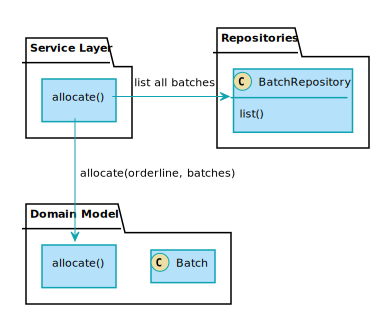

In [8]:
%%plantuml

@startuml ../images/before_aggregate

hide members
allowmixing

package "Service Layer" as ServiceLayer {
    rectangle "allocate()" as service_allocate
}

show members
hide class fields

package Repositories {
    class BatchRepository {
        list()
    }
}

package "Domain Model" as DomainModel {
    rectangle "allocate()" as domain_allocate

    class Batch
    
    domain_allocate -[hidden]> Batch
}

hide Batch members

service_allocate -> BatchRepository: list all batches
service_allocate --> domain_allocate: allocate(orderline, batches)

@enduml

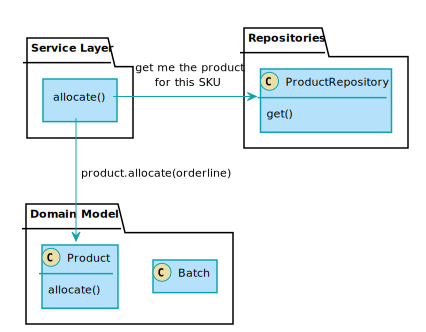

In [9]:
%%plantuml

@startuml ../images/after_aggregate

hide members
allowmixing

package "Service Layer" as ServiceLayer {
    rectangle "allocate()" as service_allocate
}

show members
hide class fields

package Repositories {
    class ProductRepository {
        get()
    }
}

package "Domain Model" as DomainModel {
    class Product {
        allocate()
    }

    class Batch
    
    Product -[hidden]> Batch
}

hide Batch members

service_allocate -> ProductRepository: "get me the product\nfor this SKU"
service_allocate --> Product: product.allocate(orderline)

@enduml

우리의 목표는 배치 도메인 모델들을 그대로 사용하여 할당하는 다음과 같은 방식을 개선하는 것입니다.

![](images/before_aggregate.svg)


개선방법은 `Product` Aggregation 을 통해 동일 품목(SKU)의 할당을 책임지게 하는 것입니다. 기존의 `allocate(orderline, batches)` 대신 `aProduct.allocate(orderline)` 라는 메소드를 통해 품목 단위로 할당하도록 하는 것입니다.  

![](images/after_aggregate.svg)

### `Product` Aggregate를 코드로 작성하기

앞서 살펴봤던 것과 같이 `Product` 는 품목별 배치들의 Aggregate이므로 동일 품목의 존재하는 모든 배치를 생성자 인수로 받습니다.

기존에 도메인 모델 모듈에 정의되었던 `models.allocate` 함수를 `Product` 모델의 메소드로 옮기면 Aggregate가 완성됩니다.

[src/domain/models/product.py]

In [10]:
from app.domain.models import Batch, OrderLine, OutOfStock

class Product:

    def __init__(self, sku: str, batches: list[Batch]):
        self.sku = sku  
        self.batches = batches  

    def allocate(self, line: OrderLine) -> str:  
        try:
            batch = next(
                b for b in sorted(self.batches) if b.can_allocate(line)
            )
            batch.allocate(line)
            return batch.reference
        except StopIteration:
            raise OutOfStock(f'Out of stock for sku {line.sku}')

이렇게 정의된 `Product` 는 우리가 일반적으로 도메인 모델링 할 때 생각하는 모델과 상당히 다릅니다.

가격이나, 상품설명, 사이즈 등의 정보가 전혀 없습니다. 그 이유는 제품 할당과 관련된 현재 컨텍스트에서 품목(SKU)을 제외한 제품의 다른 속성들은 불필요하기 때문입니다. 이처럼, 바운디드 컨텍스트(Bounded Contexts)의 힘은 앱 마다 달라지는 개념을 유연하게 다룰 수 있다는 점입니다.

#### AGGREGATES, BOUNDED CONTEXTS, AND MICROSERVICES

에릭 에반스와 DDD 커뮤니티가 가장 크게 기여한 것중 하나는 바로 [Bounded Context](https://martinfowler.com/bliki/BoundedContext.html) 의 개념입니다.

비즈니스의 전체 의미를 하나의 모델로 캡쳐하기 힘든 문제를 극복하려는 시도에서 비롯한 것입니다.

예를 들어, 고객(customer)이라는 단어는 의미는 영업, 고객관리, 물류, 지원 부서 등에서 서로 다른 의미로 사용됩니다. 따라서 속성(attributes)들도 사용하는 곳에 따라 달라집니다. 심지어 단어의 의미가 컨텍스트에 따라 완전히 바꾸기도 하기 십상입니다. 따라서 고객이라는 모델로 전체 비즈니스를 커버하기란 불가능합니다.

각 컨텍스트 경계(Bounded Context)에 여러 모델을 두고 모델간의 변환(translation)을 명시적으로 다루도록 하는 편이 좋습니다.

이런 전략은 마이크로서비스에 매우 잘 들어맞습니다. 각 마이크로서비스는 "고객"이란 모델을 자유롭게 정의할 수 있기 때문이죠. 고객을 다루는 또다른 컨텍스트(마이크로서비스와) 통신할 때는, 자신의 다른 고객 모델로 어떻게 변환할지만 고려하면 됩니다.

배치 할당을 다룬 예제에서 `Product` 모델은 `(sku, batches)`를 속성으로 가졌습니다. 반면 전자 상거래 컨텍스트에서의 `Product`는 `(sku, description, price ...)` 등 다른 속성들을 갖게 될 것입니다.

마이크로서비스를 사용하지 않더라도 Aggregate를 정할때 핵심 고려사항은 그 Aggregate가 동작할 경계 컨텍스트(Bounded Context)틀 정하는 것입니다. 제한된 컨텍스트를 통해 Aggregate의 수를 줄이고 관리가능한 크기로 유지할 수 있습니다.

## One Aggregate = One Repository

Aggregate 로 뭉질 엔티티들이 정해지면, 외부(다른 앱/또는 서비스)에 엔티티가 바로 노출되지 않고 Aggregate 단위로 노출되도록 규칙을 적용해야 합니다. 즉, 레포지터리가 Aggregate를 리턴하도록 변경해야 한다는 것입니다.

[services/uow.py]

In [11]:
from unittest.mock import MagicMock
repository = MagicMock

In [12]:
# [app/adapters/repository.py]
from typing import TypeVar, Generic, Optional
import abc
from contextlib import ContextDecorator

T = TypeVar('T')
class AbstractRepository(Generic[T], abc.ABC, ContextDecorator):
    """Repository 패턴의 추상 인터페이스 입니다."""

    @abc.abstractmethod
    def add(self, item: T) -> None:
        """레포지터리에 Aggregate 객체를 추가합니다."""
        ...

    @abc.abstractmethod
    def get(self, ref: str = '', **kwargs: str) -> Optional[T]:
        """주어진 레퍼런스 문자열에 해당하는 Aggregate 객체를 조회합니다.

        해당 Aggregate를 못 찾을 경우 ``None`` 을 리턴합니다.
        """
        ...

### 테스트를 통해 Aggregate 도메인 모델 사용법 익히기

그럼 이 Aggregate와 레포지터리를 어떻게 사용해야 할까요?

Low Gear(저단 기어)를 사용하기 적합할 때입니다. 도메인 모델 테스트를 추가하며 도메인 모델에 대한 이해도를 높혀 봅시다.

`tests/unit/test_allocate.py` 에 정의된 테스트들은 Aggregate 도입 전 `allocate` 서비스 함수를 테스트하는 테스트 케이스였습니다.

```python
def test_prefers_current_stock_batches_to_shipments() -> None:
    in_stock_batch = Batch("in-stock-batch", "RETRO-CLOCK", 100, eta=None)
    shipment_batch = Batch("shipment-batch", "RETRO-CLOCK", 100, eta=tomorrow)
    line = OrderLine("oref", "RETRO-CLOCK", 10)

    allocate(line, [in_stock_batch, shipment_batch])

    assert in_stock_batch.available_quantity == 90
    assert shipment_batch.available_quantity == 100

```

이 코드를 `Product` Aggregate의 메소드를 사용한 테스트로 바꿔봅시다.

In [13]:
from tests import mytest

from datetime import date, timedelta
import pytest
from app.domain.models import allocate, OrderLine, Batch, OutOfStock

today = date.today()
tomorrow = today + timedelta(days=1)
later = tomorrow + timedelta(days=10)

In [14]:
@mytest.test
def test_prefers_current_stock_batches_to_shipments():
    in_stock_batch = Batch("in-stock-batch", "RETRO-CLOCK", 100, eta=None)
    shipment_batch = Batch("shipment-batch", "RETRO-CLOCK", 100, eta=tomorrow)
    product = Product(sku="RETRO-CLOCK", batches=[in_stock_batch, shipment_batch])
    line = OrderLine("oref", "RETRO-CLOCK", 10)

    product.allocate(line)

    assert in_stock_batch.available_quantity == 90
    assert shipment_batch.available_quantity == 100

✅ test_prefers_current_stock_batches_to_shipments


테스트가 잘 성공합니다.

### 레포지터리와 UoW 사용해보기

6장에서 만들었떤 UoW 모델과 테스트 코드입니다.

```python
class FakeUnitOfWork(AbstractUnitOfWork):
    def __init__(self, batches: Optional[list[Batch]] = None) -> None:
        self.batches = FakeRepository(batches)
        self.committed = False

    def commit(self) -> None:
        self.committed = True

    def rollback(self) -> None:
        pass


def test_add_batch():
    uow = FakeUnitOfWork()
    services.batch.add("b1", "CRUNCHY-ARMCHAIR", 100, None, uow)
    assert uow.batches.get("b1") is not None
    assert uow.committed

```

이 코드를 `Product` 와 `AbstractProductRepository` 를 이용해 재작성해 봅시다.

In [15]:
from app.services.uow import AbstractUnitOfWork

class FakeProductRepository(AbstractRepository[Product]):
    def __init__(self, products: list[Product]):
        self._products = set(products)
        
    def add(self, product: Product):
        self._products.add(product)
        
    def get(self, sku: str) -> Optional[Product]:
        return next((p for p in self._products if p.sku == sku), None)
    
class FakeUnitOfWork(AbstractUnitOfWork):

    def __init__(self):
        self.products = FakeProductRepository([])
        self.committed = False

    def commit(self):
        self.committed = True

    def rollback(self):
        pass

변경된 코드는 쉽게 이해할 수 있습니다. 한가지 복잡해보이는 코드는 `get` 함수의 리턴문입니다.

```python
  return next((p for p in self._products if p.sku == sku), None)
```

이 코드를 아래와 같이 이해하기 쉽게 재작성할 수 있습니다.

```python
  found = [p for p in self._proudcts if p.sku == sku]
  return found[0] if found else None
```

하지만 근본적인 차이점은 무엇일까요? 만일 `_products` 에 10억개의 제품이 있다고 한다면 위 코드는 10억개 원소를 가진 리스트를 메모리에 먼저 빌드합니다. 결과를 리턴하는에 엄청난 리소스와 시간을 낭비하게 됩니다. 반면에 `(p for p in ...)` 문은 제너레이터와 `next` 이터레이터 메소드로 구현되어 메모리 로드 없이 최초 발견한 1개의 원소를 바로 리턴하도록 한 것입니다.

그런데 테스트를 해보면 실패합니다.

In [16]:
from app import services
@mytest.test
def test_add_batch_for_new_product():
    uow = FakeUnitOfWork()
    services.batch.add("b1", "CRUNCHY-ARMCHAIR", 100, None, uow)
    assert uow.batches.get("b1") is not None
    assert uow.committed

❌ test_add_batch_for_new_product


Traceback (most recent call last):
  File "/home/ykkim/notebooks/2021-msa-study/07-aggregates-boundaries/app/services/batch.py", line 30, in add
    uow.batches.add(Batch(ref, sku, qty, eta))
AttributeError: 'FakeUnitOfWork' object has no attribute 'batches'


그 이유는 기존에 정의된 `services.batch.add` 함수에서 사용한 `AbstractUnitOfWork` 구현이 바뀌었기 때문입니다.

테스트가 성공하도록 서비스 함수 구현을 수정해 봅시다.

In [17]:
from app.services.batch import InvalidSku

def add_batch(ref: str, sku: str, qty: int, eta: Optional[date],
              uow: AbstractUnitOfWork) -> None:
    with uow:
        product = uow.products.get(sku)
        if not product:
            product = Product(sku, batches=[])
            uow.products.add(product)
        product.batches.append(Batch(ref, sku, qty, eta))
        uow.commit()
        
def allocate(orderid: str, sku: str, qty: int, 
             uow: AbstractUnitOfWork) -> str:
    line = OrderLine(orderid, sku, qty)
    with uow:
        product = uow.products.get(sku=line.sku)
        if product is None:
            raise InvalidSku(f'Invalid sku {line.sku}')
        batchref = product.allocate(line)
        uow.commit()
    return batchref

services = MagicMock()
services.batch.add = add_batch
services.batch.allocate = allocate

다시 테스트를 실행시키면 테스트가 정상적으로 동작함을 알 수 있습니다.

In [18]:
@mytest.test
def test_add_batch_for_new_product():
    uow = FakeUnitOfWork()
    services.batch.add("b1", "CRUNCHY-ARMCHAIR", 100, None, uow)
    assert uow.products.get("CRUNCHY-ARMCHAIR") is not None
    assert uow.committed

✅ test_add_batch_for_new_product


In [19]:
@mytest.test
def test_allocate_returns_allocation():
    uow = FakeUnitOfWork()
    services.batch.add("batch1", "COMPLICATED-LAMP", 100, None, uow)
    result = services.batch.allocate("o1", "COMPLICATED-LAMP", 10, uow)
    assert "batch1", result

✅ test_allocate_returns_allocation


## What About Performance?

Aggregate를 사용하는 이유 중 하나가 락킹 최소화를 통한 성능 향상이었으니 성능에 대해서도 살펴보겠습니다.

결론적으로 현재까지의 구현상에는 성능상의 문제점이 좀 보입니다. `Product` Aggregate 의 생성자 때문입니다.

```
class Product:

    def __init__(self, sku: str, batches: list[Batch]):
        self.sku = sku  
        self.batches = batches  
        
    ...
```

현재 구현에서는 `Product` 생성시에 전체 배치가 로드되어 있어야 합니다. 어떤 품목에 대한 배치가 10억개가 있다고 가정하면 쉽게 상상이 갈 것입니다.

하지만 (저자의 말에 의하면) 실제 유즈케이스 상에서 품목당 배치는 많아야 수십개 이하라고 하며, 수 만개 이상 되더라도 `Batch` 모델의 속성이 몇개 안되어 로드하는데 큰 부하는 없다고 말합니다.

만일 시스템의 규모가 커져 많은 배치를 다루게 될경우 Lazy Loading 방식을 이용해 개선하면 될 것입니다. 그 경우에도 감당이 안된다면 Aggregate를 좀더 작은 단위로 세분화 하면 될 것입니다.

## Optimistic Concurrency with Version Numbers

여기까지 로직 레벨에서 일관성의 경계를 책임지는 Aggregate를 만들고 사용하는 방법을 확인했습니다. 이제 실제 DB 레벨에서 데이터 정합성을 확보하는 방법을 살펴보겠습니다.

### 특정 품목의 배치들에 대해서만 락 걸기

품목별 배치를 `Product`로 묶기 전에는 여러 트랜잭션들이 할당을 처리하는 도중 동일 품목의 배치를 잘 못 할당하는 것을 막기 위해 `batch` 테이블 전체에 락을 거는 수밖에 없었습니다.

특정 품목에 대해서만 락을 걸기 위해서는 소프트웨어적인 락이 필요합니다. 가장 간단한 방법은 `version_number` 라는 상태 변경 마커를 하나 만들어 동시성 작업의 유일한 리소스로 만드는 것입니다. 여러 트랜잭션이 할당 서비스를 통해 배치 전체 상태를 읽어 할당 테이블을 업데이트 시도하는 경우, `version_number` 를 체크하여 둘 중 하나가 먼저 커밋한 경우 나머지 커밋 시도를 무효화 하여 일관성이 유지되도록 하는 것입니다.

![](images/ch7-seq-diagram-1.svg)

위 시퀀스 다이어그램은 동시에 할당 작업을 시도하는 두 트랜잭션의 처리과정을 나타냅니다. 두 트랜잭션은 `version`이 `3`인 `Product` 에 대해 동시에 `allocate` 메소드를 호출합니다. 둘 중 어느 트랜잭션이 먼저 수행될지는 알 수 없지만, 제품이 할당되는 시점에 한 트랜잭션에 의해 버전이 `4`로 올라갈 경우 다른 트랜잭션의 요청은 버전 불일치 체크를 통해 취소처리 할 수 있습니다.

#### OPTIMISTIC CONCURRENCY CONTROL AND RETRIES

이 교재에서 동시성을 제하는 방식을 "낙관적 동시성 제어" 라고 합니다. 두 사용자가 데이터베이스를 동시에 변경하려 할 때 모든것이 정상이라고 가정하는 방식입니다. 동시 변경이 충돌할 가능성이 낮기 때문에 동시 변경을 허용하고 문제가 발생시 확실히 통보받을 수 있도록 하는것입니다.

반면에 "비관적 동시성 제어" 방식에서는 항상 충돌이 발생한다는 가정하에 동시작업을 설계합니다. 따라서 모든 변경작업에 락을 걸어 안전을 보장해야 합니다. 배치 할당 예제에서 이 말은 모든 배치 테이블에 락을 걸거나 `SELECT FOR UPDATE` 문을 사용해서 조회된 전체 행에 대한 락을 걸어야 함을 의미합니다. 이 책에서는 성능상의 문제로 이런 방식을 사용하지 않는다고 가정했지만 실제 프로젝트에서는 성능 평가를 직접 해봐야 합니다.

성능상의 문제에도 불구하고 비관적 락킹은 변경 충돌을 원천적으로 차단하므로 장애 처리가 필요 없다는 장점이 있습니다. (물론 데드락의 발생을 고려해야 합니다) 반면 낙관적 락킹시에는 충돌로 인한 실패를 명시적으로 처리해야 합니다.

실패 처리의 일반적인 방법은 작업을 처음부터 다시 시도하는 것입니다. 대부분의 작업은 동시성 문제가 발생할 경우 이러한 방식으로 재시도할 수 있습니다.

### Implementation Options for Version Numbers

버전 번호를 구현하는 방법에는 세가지 옵션이 있습니다.

1. 도메인에서 처리하기: `Product.allocate()` 메소드가 버전 번호 증가를 책임집니다.
2. 서비스 계층에서 처리하기: 엄밀히 말해 버전번호를 통한 동시성 제어는 도메인 관심사가 아닙니다. 따라서 서비스 레이어가 이 책임을 대신 맞는게 적합할 수 있습니다. 커밋 전에 버전 번호를 증가시키는 방식을 사용합니다.
3. UoW에서 처리하기: UoW가 커밋할 때 Aggregate들에 변경이 일어났다고 가정하고 레포지터리에 로드된 모든 `Product`의 버전 번호를 증가시키는 것입니다.

3번의 경우 모든 `Product` 버전이 동시에 올라간다 가정이 말이 안되기 때문에 제외하고, 2번의 경우는 서비스 레이어와 도메인 레이어간의 상태 변경의 책임이 섞여 다소 혼란스럽습니다.

따라서 가장 깔끔한 절충안은 그냥 도메인에 버전 관리 책임을 두는 것입니다.

In [21]:
class Product:

    def __init__(self, sku: str, batches: list[Batch], version_number: int = 0):  
        self.sku = sku
        self.batches = batches
        self.version_number = version_number  

    def allocate(self, line: OrderLine) -> str:
        try:
            batch = next(
                b for b in sorted(self.batches) if b.can_allocate(line)
            )
            batch.allocate(line)
            self.version_number += 1  
            return batch.reference
        except StopIteration:
            raise OutOfStock(f'Out of stock for sku {line.sku}')

## Testing for Our Data Integrity Rules

이제 DB에서 우리가 만든 동시성 제어 방식이 제대로 동작하는지 테스트해볼 차례입니다.

#### 테스트 준비: ORM기반 레포지터리와 UoW 고치기

먼저 ORM 에서 Aggregate 객체를 인식하도록 매핑을 추가합니다.

In [22]:
from sqlalchemy import MetaData, Table, Column, String, Integer, Date, ForeignKey
from sqlalchemy.orm import relationship, mapper, Session
from app.adapters import orm
from app.domain.models import Batch, OrderLine

def start_mappers(use_exist: bool = True) -> MetaData:
    metadata = orm.start_mappers(use_exist) # 기존 매퍼
    allocation = metadata.tables['allocation']
    order_line = metadata.tables['order_line']
    batch = Table('batch', metadata,
              Column('id', Integer, primary_key=True, autoincrement=True),
              Column('reference', String(255), unique=True),
              Column('_purchased_quantity', Integer),
              Column('sku', ForeignKey('product.sku')), # 외래키 관계 추가
              Column('eta', Date, nullable=True),
              extend_existing=True)
    
    _order_line_mapper = mapper(OrderLine, order_line)
    _batch_mapper = mapper(Batch, batch, properties={
        '_allocations': relationship(OrderLine, secondary=allocation, 
                                     collection_class=set, lazy='joined'),
    })    
    
    # Aggregate 매핑 추가
    product = Table('product', metadata,
        Column('sku', String(255), primary_key=True),
        Column('version_number', Integer, nullable=False, server_default='0'),
        extend_existing=True
    )

    prouct_mapper = mapper(Product, product, properties={
        'batches': relationship(Batch)
    })

    return metadata

이 매핑을 이용한 기본 Session 팩토리를 만듭니다.

In [23]:
from tests import mytest

@mytest.fixture
def get_session():
    from sqlalchemy.orm import sessionmaker, Session
    from app import config
    orm.clear_mappers()
    engine = orm.init_engine(start_mappers(), config.get_db_url())
    return sessionmaker(engine)

DEFAULT_SESSION_FACTORY = get_session

마지막으로 기존에 만들었더 SqlAlchemy ORM 기반의 레포지터리와 와 UoW를 Aggregate 를 사용한 구현으로 수정합니다

In [24]:
class SqlAlchemyProductRepository(AbstractRepository[Product]):
    def __init__(self, session: Session):
        self.session = session  # pylint: disable=invalid-name

    def add(self, product: Product) -> None:
        self.session.add(product)

    def get(self, sku):
        return self.session.query(Product).filter_by(sku=sku).first()


class SqlAlchemyUnitOfWork(AbstractUnitOfWork):

    def __init__(self, session_factory=DEFAULT_SESSION_FACTORY):
        self.session_factory = session_factory

    def __enter__(self):
        self.session = self.session_factory()  # type: Session
        self.products = SqlAlchemyProductRepository(self.session)
        return super().__enter__()

    def __exit__(self, *args):
        super().__exit__(*args)
        self.session.close()

    def commit(self):
        self.session.commit()

    def rollback(self):
        self.session.rollback()

#### 동시성 테스트를 위한 시뮬레이션 코드 작성하기

우선 해야 할 작업은 트랜잭션 작업 사이에 Sleep을 두어 "느린" 트랜잭션을 흉내내보는 겁니다.

다음 `try_to_allocate` 함수는 앞에서 봤던 시퀀스 다이어그램에서 한 Transaction이 하던 작업과 유사한 작업을 합니다. 데이터베이스에서 제품 정보를 조회한 후, 제품을 할당하고, 제품의 버전을 증가시킵니다. 단, 버전을 증가시키는 작업은 `Product.allocate` 에서 암시적으로 이루어집니다.

In [25]:
import time

from app.domain.models import OrderLine

def try_to_allocate(uow: AbstractUnitOfWork, orderid, sku, exceptions):
    line = OrderLine(orderid, sku, 10)
    try:
        with uow:
            product = uow.products.get(sku=sku)
            product.allocate(line)
            time.sleep(0.2)
            uow.commit()
    except Exception as e:
        # print(traceback.format_exc())
        exceptions.append(e)

테스트 픽스처 `uow_with_product`를 만들어 보겠습니다. 이 픽스쳐는 임의의 SKU로 테스트 데이터를 셋업한 뒤 UoW를 리턴합니다. 뿐만아니라 테스트가 끝나면 테스트 데이터를 자동으로 클리어 합니다.

In [26]:
from app.domain.models import Batch

from tests import random_batchref, random_sku, random_orderid

def cleanup_sku(session, sku: str):
    session.execute('''DELETE FROM allocation WHERE batch_id in (
        SELECT id FROM batch WHERE sku=:sku)''', dict(sku=sku))
    session.execute('''DELETE FROM allocation WHERE orderline_id in (
        SELECT id FROM order_line WHERE sku=:sku)''', dict(sku=sku))    
    session.execute("DELETE FROM order_line WHERE sku=:sku", dict(sku=sku))
    session.execute("DELETE FROM batch WHERE sku=:sku", dict(sku=sku))
    session.execute("DELETE FROM product WHERE sku=:sku", dict(sku=sku))
    session.commit()
    
@mytest.fixture
def uow_with_product(get_session):
    _sku = ''
    session = get_session()
    
    def wrapper(sku: str = '', qty=100, eta=None, product_version=1):
        nonlocal _sku
        if not sku:
            sku = random_sku()
        _sku = sku # 클린업을 위해 sku 기억
        uow = SqlAlchemyUnitOfWork(lambda: session)
        batch = Batch(ref=random_batchref(), sku=sku, qty=qty, eta=eta)
        session.add(batch)
        product = Product(sku, batches=[batch], version_number=product_version)
        session.add(product)
        session.commit()
        return uow
        
    cleanup_sku(session, _sku)
    yield wrapper
    session.rollback()
    cleanup_sku(session, _sku)

이 픽스처를 이용해 `try_to_allocate` 사용법을 테스트해봅시다.

In [27]:
@mytest.test
def test_try_to_allocate(uow_with_product):
    sku = 'TEST-SKU'
    exceptions = []
    uow = uow_with_product(sku, product_version=1)
    
    try_to_allocate(uow, 'TEST-ORDER', sku, exceptions)

    [[version_number]] = uow.session.execute(
        'SELECT version_number FROM product WHERE sku=:sku', dict(sku=sku))
    
    [[qty]] = uow.session.execute(
        'SELECT _purchased_quantity FROM batch WHERE sku=:sku', dict(sku=sku))
    
    assert 2 == version_number
    assert 100 == qty, f"batch qty is mismatched: 0 !== {qty}"
    
    
#@mytest.test
def test_cleanup_completed(get_session):
    session = get_session()
    session.execute('DELETE FROM allocation')
    session.execute('DELETE FROM order_line')
    session.execute('DELETE FROM batch')
    session.execute('DELETE FROM product')
    session.commit()
    
@mytest.test
def test_cleanup_completed(get_session):
    session = get_session()
    [[product_cnt]] = session.execute('SELECT count(*) FROM product')
    [[batch_cnt]] = session.execute('SELECT count(*) FROM batch')
    [[alloc_cnt]] = session.execute('SELECT count(*) FROM allocation')
    assert 0 == product_cnt
    assert 0 == batch_cnt
    assert 0 == alloc_cnt

❌ test_try_to_allocate


Traceback (most recent call last):
  File "/home/ykkim/conda/envs/lab/lib/python3.9/site-packages/sqlalchemy/orm/mapper.py", line 1289, in _configure_class_instrumentation
    raise sa_exc.ArgumentError(
sqlalchemy.exc.ArgumentError: Class '<class 'app.domain.models.OrderLine'>' already has a primary mapper defined. Use non_primary=True to create a non primary Mapper.  clear_mappers() will remove *all* current mappers from all classes.


✅ test_cleanup_completed


이제 드디어 동시성 테스트를 해볼 차례입니다. 

1. 스레드 2개로 동시에 제품 버전정보를 얻고 주문선에 배치를 할당하도록 할 것입니다.
2. 배치 할당이 완료되면 각 스레드에서 동시에 버전을 업데이트 하려 할 것입니다.
3. 두 스레드 중 한 스레드만 업데이트에 성공하여 버전을 1만 증가한 상태가 됩니다.
4. 나머지 스레드는 업데이트 에러 발생하여 예외 상태가 됩니다.

이 작업을 테스트 코드로 작성해서 실행해보겠습니다.

In [28]:
import threading

@mytest.test
def test_concurrent_updates_to_version_are_not_allowed(uow_with_product, get_session):
    sku = random_sku()
    uow = uow_with_product(sku=sku, qty=100)

    order1, order2 = random_orderid(1), random_orderid(2)
    exceptions = []  # type: List[Exception]
    def try_to_allocate_order(order: str):
        temp_uow = SqlAlchemyUnitOfWork(get_session)
        return threading.Thread(target=lambda: \
            try_to_allocate(temp_uow, order1, sku, exceptions))
       
    # 두 스레드가 배치에 동시에 주문선을 할당 후 버전을 업데이트 하려는 상황을 시뮬레이션합니다.        
    thread1, thread2 = try_to_allocate_order(order1), try_to_allocate_order(order2) 
    thread1.start(), thread2.start()
    thread1.join(), thread2.join() 

    session = get_session()
    [[version]] = session.execute(
        "SELECT version_number FROM product WHERE sku=:sku",
        dict(sku=sku),
    )
    # 두 스레드가 동시에 할당을 시도했지만 오직 한 스레드만 성공하여 버전은 한 번만 증가합니다.
    assert version == 2
    
    [exception] = exceptions
    assert 'could not serialize access due to concurrent update' in str(exception)  

    orders = list(session.execute(
        "SELECT orderid FROM allocation"
        " JOIN batch ON allocation.batch_id = batch.id"
        " JOIN order_line ON allocation.orderline_id = order_line.id"
        " WHERE order_line.sku=:sku",
        dict(sku=sku),
    ))
    assert len(orders) == 1  
    with uow:
        uow.session.execute('select 1')

❌ test_concurrent_updates_to_version_are_not_allowed


Traceback (most recent call last):
  File "<ipython-input-28-fb4d46c3a766>", line 28, in test_concurrent_updates_to_version_are_not_allowed
    [exception] = exceptions
ValueError: not enough values to unpack (expected 1, got 0)


그런데, 테스트가 실패했습니다. 예외가 발생할 것이라고 생각했는데 아무런 예외도 발생하지 않았기 때문입니다. 사실 당연합니다. 지금까지 동시 업데이트 시도에 대한 예외처리 코드를 작성하지 않았기 때문입니다.

#### Enforcing Concurrency Rules by Using Database Transaction Isolation Levels

SQL 표준으로 제정된 격리 레벨을 이용하면 이런 변경 충돌을 쉽게 처리할 수 있습니다.

`REPEATABLE READ` 격리 모드는 다른 트랜잭션이 커밋한 데이터를 읽지 못하도록 격리시키는 모드로, 위 테스트에서 한 트랜잭션이 `version_number`를 증가시키면 다른 트랜잭션은 더이상 이 값을 읽지 못하여 에러가 발생합니다.

- *See also*:

  격리 레벨(Isolation Level)에 대해서는 [PostgreSQL 관련 문서](https://postgresql.kr/docs/11/transaction-iso.html) 를 참고하세요

이제 격리 레벨을 지원하도록 `get_session` 픽스처를 변경한 뒤 다시 테스트 해보겠습니다.

In [29]:
@mytest.fixture
def get_session():
    from sqlalchemy.orm import sessionmaker, Session
    from app import config
    orm.clear_mappers()
    engine = orm.init_engine(start_mappers(), config.get_db_url(), isolation_level="REPEATABLE READ")
    return sessionmaker(engine)

mytest.run(test_concurrent_updates_to_version_are_not_allowed)

✅ test_concurrent_updates_to_version_are_not_allowed


테스트가 잘 성공함을 알 수 있습니다.

#### Pessimistic Concurrency Control Example: `SELECT FOR UPDATE`

비관적인 동시성 제어방법을 사용할 수 도 있습니다. 동시에 두 트랜잭션이 동일 SKU에 대한 `Product` 를 가져올 수 없도록 락을 걸어 막는 방법입니다.

이 방법을 사용하면 한 트랜잭션이 커밋후 락을 릴리즈하기 전까지 다른 트랜잭션은 대기하게 됩니다. 이 방법을 사용하면 별도의 예외처리는 필요하지 않겠지만 대신 성능 저하가 발생할 것입니다.

In [30]:
class PessimisticSqlAlchemyProductRepository(SqlAlchemyProductRepository):

    def get(self, sku):
        return self.session.query(model.Product) \
                           .filter_by(sku=sku) \
                           .with_for_update() \
                           .first()

class PessimisticSqlAlchemyUnitOfWork(SqlAlchemyUnitOfWork):

    def __enter__(self):
        self.session = self.session_factory()  # type: Session
        self.products = PessimisticSqlAlchemyProductRepository(self.session)
        return super().__enter__()

## Wrap-Up

후반부에서는 동시성 제어를 구현하는데 집중했습니다. 다시 챕터 처음에 논의했던 Aggregate의 개념을 되짚으며 이 장을 마무리해봅시다.

우리는 Aggregate를 특정 컨텍스트에서 모델 덩어리를 다루는 진입점으로 명시적으로 모델링하고, 모든 객체에 적용되는 불변성 및 비즈니스 규칙을 담당하도록 했습니다.

상황에 따라 올바른 Aggregate를 선택하는 것이 핵심이며, 시간이 지남에 따라 재검토가 필요한 결정 사항입니다.

여러 DDD 책에서 Aggregate를 다루고 있습니다. 본 버논("red book")의 효과적인 Aggregate 설계에 관한온라인 논문들을 읽기를 추천합니다.